# Compare graph theory metrics

Check if graph-tools is faster than brainconn and compare answers

# Load in the required libraries

In [1]:
import timecorr as tc
import numpy as np
import brainconn as bc
import graph_tool.all as gt
import matplotlib 
matplotlib.use('Agg') 
%matplotlib inline

In [2]:
def apply_by_row(corrs, f):
    '''
    apply the function f to the correlation matrix specified in each row, and return a
    matrix of the concatenated results

    :param corrs: a matrix of vectorized correlation matrices (output of mat2vec), or a list
                  of such matrices
    :param f: a function to apply to each vectorized correlation matrix
    :return: a matrix of function outputs (for each row of the given matrices), or a list of
            such matrices
    '''

    if type(corrs) is list:
        return list(map(lambda x: apply_by_row(x, f), corrs))

    corrs = tc.vec2mat(corrs) #V by V by T
    return np.stack(list(map(lambda x: f(np.squeeze(x)), np.split(corrs, corrs.shape[2], axis=2))), axis=0)

## Simulate data and first order correlations

In [3]:
sim_data = tc.simulate_data(T=1000, K=300, set_random_seed=100)

In [4]:
sim_data.shape

(1000, 300)

In [5]:
# calculate correlations  - returned squareformed
tc_data = tc.timecorr(sim_data, weights_function=tc.gaussian_weights, weights_params={'var': 5})


In [6]:
tc_data.shape

(1000, 45150)

## Time current eigenvector reduction implentation

In [7]:
%%time
r_data = tc.reduce(tc_data, rfun='eigenvector_centrality')

CPU times: user 2min 6s, sys: 2min 8s, total: 4min 14s
Wall time: 1min 5s


In [8]:
r_data.shape

(1000, 300)

In [9]:
%%time
r_a_data = apply_by_row(tc_data, bc.centrality.eigenvector_centrality_und)

CPU times: user 2min 23s, sys: 2min 30s, total: 4min 54s
Wall time: 1min 15s


In [10]:
r_a_data.shape

(1000, 300)

## Convert to matrix shape

In [11]:
corrs = tc.vec2mat(tc_data) 

In [12]:
corrs.shape

(300, 300, 1000)

In [13]:
one_corr = corrs[:, :, -1]

In [14]:
one_corr.shape

(300, 300)

## Use brainconn eigenvector centrality measure and time it

In [15]:
%%time
bc_eig = bc.centrality.eigenvector_centrality_und(one_corr)

CPU times: user 190 ms, sys: 230 ms, total: 420 ms
Wall time: 139 ms


In [16]:
bc_eig

array([0.01831336, 0.08586577, 0.06020545, 0.09440946, 0.05559391,
       0.06161274, 0.03705954, 0.0239453 , 0.06183445, 0.0904868 ,
       0.0702778 , 0.0335146 , 0.01981774, 0.07960358, 0.02870026,
       0.08508604, 0.03806821, 0.00112498, 0.03473792, 0.05219319,
       0.07003443, 0.09226025, 0.03316524, 0.00133616, 0.02429001,
       0.05374146, 0.0195433 , 0.08754593, 0.01763324, 0.05675277,
       0.00073872, 0.02119119, 0.08441002, 0.08636862, 0.02406572,
       0.02444056, 0.04576551, 0.11504933, 0.0029847 , 0.00341266,
       0.03606793, 0.05074344, 0.02613736, 0.02856375, 0.08188825,
       0.10361321, 0.00122741, 0.06433783, 0.05492514, 0.062596  ,
       0.06247127, 0.04194388, 0.09137385, 0.05196918, 0.02402521,
       0.05897803, 0.01194672, 0.00800043, 0.01598492, 0.06839405,
       0.11504371, 0.06103375, 0.06684244, 0.05918169, 0.08045377,
       0.03294111, 0.04956371, 0.01489359, 0.02579519, 0.07497876,
       0.01958325, 0.02445949, 0.00262159, 0.03711478, 0.05975

## Figure out this graph class

In [17]:
N = len(one_corr)
g = gt.Graph()
g.set_directed( False )
corr_w = g.new_edge_property("double")
v = [ g.add_vertex() for i in range(N) ]
for i in range(N):
    for j in range(i):
        e1 = g.add_edge( v[i], v[j] )
        e2= g.add_edge(v[j], v[i])
        corr_w[e1] = one_corr[i, j]
        corr_w[e2]= one_corr[j, i]

In [18]:
g.get_edges()

array([[    0,     1,     1],
       [    0,     2,     3],
       [    0,     3,     7],
       ...,
       [  299,   296, 89694],
       [  299,   297, 89696],
       [  299,   298, 89698]], dtype=uint64)

In [19]:
%%time
ee, w = gt.eigenvector(g, weight=corr_w)

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 23.2 ms


In [20]:
gt_eig = w.get_array()

In [21]:
gt_eig

PropertyArray([-0.01831336, -0.08586577, -0.06020545, -0.09440946,
                0.05559391, -0.06161274,  0.03705954,  0.0239453 ,
               -0.06183446,  0.0904868 ,  0.0702778 , -0.0335146 ,
               -0.01981773, -0.07960358,  0.02870026,  0.08508604,
               -0.03806821, -0.00112498, -0.03473792,  0.05219319,
               -0.07003443, -0.09226025,  0.03316524, -0.00133616,
                0.02429001, -0.05374146, -0.0195433 , -0.08754593,
                0.01763324,  0.05675277, -0.00073872,  0.02119119,
               -0.08441002, -0.08636862,  0.02406572, -0.02444056,
               -0.04576551,  0.11504933, -0.0029847 ,  0.00341266,
                0.03606793,  0.05074344, -0.02613736,  0.02856375,
               -0.08188825,  0.10361321, -0.00122741,  0.06433783,
                0.05492514,  0.062596  ,  0.06247127, -0.04194388,
                0.09137385, -0.05196918,  0.02402521,  0.05897803,
               -0.01194672, -0.00800043, -0.01598492,  0.06839

In [22]:
one_corr.ravel()[2]

0.02164224596455712

In [23]:
gt_eig[6]

0.03705954041915637

## Give the same absolute value results.. hmm

In [24]:
np.allclose(np.abs(gt_eig), bc_eig)

True

In [27]:
g.is_directed() == False

True

## What about pagerank?

In [28]:
N = len(one_corr)
g = gt.Graph()
g.set_directed( False )
corr_w = g.new_edge_property("double")
v = [ g.add_vertex() for i in range(N) ]
for i in range(N):
    for j in range(i):
        e1 = g.add_edge( v[i], v[j] )
        e2= g.add_edge(v[j], v[i])
        corr_w[e1] = one_corr[i, j]
        corr_w[e2]= one_corr[j, i]

In [29]:
bc_pr = bc.centrality.pagerank_centrality(one_corr, d=0.85)

In [30]:
bc_pr

array([ 5.48008597e-02, -4.74432595e-02,  1.53420047e-02, -4.22281342e-02,
        2.26402592e-02, -9.40306606e-03,  2.45618637e-02,  1.06939151e-02,
        9.19301916e-03, -4.10254611e-02,  3.17912819e-02,  8.26940644e-02,
        3.01262128e-02,  4.90941962e-03,  9.88596373e-02, -1.07831796e-02,
        2.98321403e-02,  1.62736033e-01, -1.39792262e-02, -2.39599114e-02,
       -8.26354240e-03, -1.55702415e-02,  1.35352527e-01,  4.71257653e-03,
       -4.70721552e-02, -2.28579230e-02,  2.49991341e-02, -1.20569850e-02,
        6.59037171e-03,  6.41253589e-02,  1.77010953e-01,  3.38768430e-02,
       -1.66859315e-02,  2.55253662e-03, -1.18619035e-01,  1.13535659e-01,
       -1.87473586e-02,  3.87540429e-03, -4.08859027e-03, -1.38097155e-01,
       -9.61678645e-03,  1.40888707e-01, -9.30240758e-02, -2.94067585e-02,
       -3.18746609e-02,  5.64965400e-02, -1.24388629e-02,  2.39772496e-02,
        9.62958192e-02, -1.95775517e-02, -8.79452702e-03,  5.66783243e-03,
       -5.76207767e-03,  

In [31]:
gt_pr = gt.pagerank(g, weight=corr_w)

## not the same... only infs or nans for some reason

In [32]:
gt_pr.get_array()

PropertyArray([-8.55931384e+307, -5.23974515e+307, -9.67123109e+307,
                2.63706746e+307, -3.52861606e+307, -4.77291193e+307,
                1.94515931e+307,  4.02832692e+307, -7.06417897e+307,
                7.05304066e+307, -3.03084611e+306, -2.26757963e+306,
               -4.65118046e+307,  1.89473252e+307, -5.83436315e+303,
                1.28244995e+308,  4.81267987e+307, -8.02708577e+307,
                1.47864396e+307,  6.37621611e+307, -3.25747621e+307,
               -7.06901229e+307, -6.68094073e+307,  6.64577142e+306,
               -2.91923281e+307, -7.24016307e+307,  3.74543415e+307,
               -1.35634322e+308,  5.63794587e+307,  7.00892338e+307,
                4.91968475e+307,  2.92504302e+307, -8.27977108e+307,
                1.96066001e+306,  2.93555602e+307,  4.94015492e+307,
               -6.47043012e+307,  5.93542353e+307,  9.70953920e+306,
               -7.89876490e+305, -1.52752036e+307, -1.10980918e+308,
                7.94045221e+307,  

In [33]:
one_corr

array([[ 1.        ,  0.04863098,  0.02164225, ...,  0.03929638,
        -0.02643856, -0.03673294],
       [ 0.04863098,  1.        ,  0.07256212, ..., -0.07548218,
        -0.05142836, -0.12823811],
       [ 0.02164225,  0.07256212,  1.        , ..., -0.02785322,
        -0.01055677, -0.14620686],
       ...,
       [ 0.03929638, -0.07548218, -0.02785322, ...,  1.        ,
        -0.01445154,  0.00116845],
       [-0.02643856, -0.05142836, -0.01055677, ..., -0.01445154,
         1.        , -0.01816898],
       [-0.03673294, -0.12823811, -0.14620686, ...,  0.00116845,
        -0.01816898,  1.        ]])

## debug with sample data

### Using asymetric matix

In [194]:
a_sample_data = np.array([[1,.011,-.0124, .0234], [.0343,1,-.0114, .0432], [.0323,-.0141,1, .0534], [.0443,.0332,.134,1]])

In [195]:
a_sample_data

array([[ 1.    ,  0.011 , -0.0124,  0.0234],
       [ 0.0343,  1.    , -0.0114,  0.0432],
       [ 0.0323, -0.0141,  1.    ,  0.0534],
       [ 0.0443,  0.0332,  0.134 ,  1.    ]])

In [196]:
N = len(a_sample_data)
g = gt.Graph()
g.set_directed( True )
corr_w = g.new_edge_property("double")
v = [ g.add_vertex() for i in range(N) ]
for i in range(N):
    for j in range(i):
        e1 = g.add_edge( v[i], v[j] )
        e2= g.add_edge(v[j], v[i])
        corr_w[e1] = a_sample_data[i, j]
        corr_w[e2]= a_sample_data[j, i]

In [197]:
g.get_edges()

array([[ 0,  1,  1],
       [ 0,  2,  3],
       [ 0,  3,  7],
       [ 1,  0,  0],
       [ 1,  2,  5],
       [ 1,  3,  9],
       [ 2,  0,  2],
       [ 2,  1,  4],
       [ 2,  3, 11],
       [ 3,  0,  6],
       [ 3,  1,  8],
       [ 3,  2, 10]], dtype=uint64)

In [198]:
corr_w.get_array()

PropertyArray([ 0.0343,  0.011 ,  0.0323, -0.0124, -0.0141, -0.0114,
                0.0443,  0.0234,  0.0332,  0.0432,  0.134 ,  0.0534])

In [199]:
ee, w = gt.eigenvector(g, weight=corr_w)

In [200]:
w.get_array()

PropertyArray([0.50870156, 0.14530027, 0.65456818, 0.54004727])

In [201]:
bc_eig = bc.centrality.eigenvector_centrality_und(a_sample_data)

In [202]:
bc_eig

array([0.17567724, 0.36230938, 0.44107338, 0.80207462])

In [203]:
a_sample_data

array([[ 1.    ,  0.011 , -0.0124,  0.0234],
       [ 0.0343,  1.    , -0.0114,  0.0432],
       [ 0.0323, -0.0141,  1.    ,  0.0534],
       [ 0.0443,  0.0332,  0.134 ,  1.    ]])

### with symetric matrix

In [204]:
a_sample_data = np.array([[1,.011,-.0124, .0234], [.0343,1,-.0114, .0432], [.0323,-.0141,1, .0534], [.0443,.0332,.134,1]])

In [205]:
s_sample_data = np.triu(a_sample_data) + np.triu(a_sample_data).T
np.fill_diagonal(s_sample_data, 1)

In [206]:
s_sample_data

array([[ 1.    ,  0.011 , -0.0124,  0.0234],
       [ 0.011 ,  1.    , -0.0114,  0.0432],
       [-0.0124, -0.0114,  1.    ,  0.0534],
       [ 0.0234,  0.0432,  0.0534,  1.    ]])

In [207]:
N = len(s_sample_data)
g = gt.Graph()
g.set_directed( True )
corr_w = g.new_edge_property("double")
v = [ g.add_vertex() for i in range(N) ]
for i in range(N):
    for j in range(i):
        e1 = g.add_edge( v[i], v[j] )
        e2= g.add_edge(v[j], v[i])
        corr_w[e1] = s_sample_data[i, j]
        corr_w[e2]= s_sample_data[j, i]

In [208]:
ee, w = gt.eigenvector(g, weight=corr_w)

In [209]:
w.get_array()

PropertyArray([ 0.2305872 ,  0.42063113,  0.55727393, -0.67774978])

In [212]:
bc_eig = bc.centrality.eigenvector_centrality_und(s_sample_data)

In [213]:
bc_eig

array([0.2406776 , 0.43262969, 0.4658377 , 0.7334174 ])

In [103]:
try_corr = one_corr[:4, :4]

In [214]:
try_corr

array([[1.        , 0.04863098, 0.02164225, 0.09679796],
       [0.04863098, 1.        , 0.07256212, 0.10291719],
       [0.02164225, 0.07256212, 1.        , 0.07459299],
       [0.09679796, 0.10291719, 0.07459299, 1.        ]])

In [104]:
try_corr.shape


(4, 4)

In [145]:
import seaborn as sns

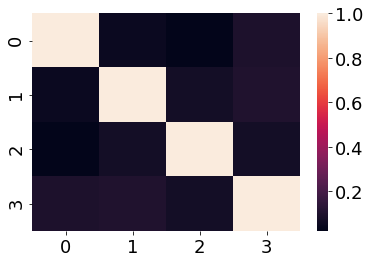

In [146]:
sns.heatmap(try_corr)

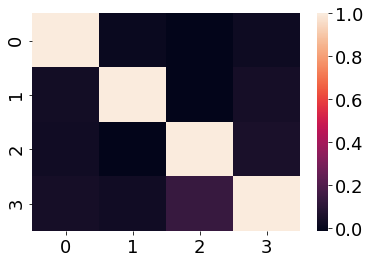

In [147]:
sns.heatmap(sample_data)

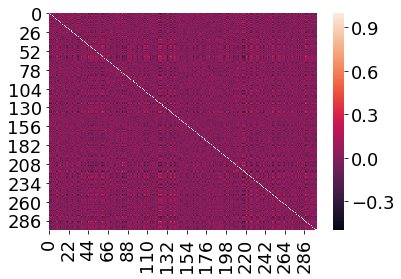

In [148]:
sns.heatmap(one_corr)

In [149]:
N = len(try_corr)
g = gt.Graph()
g.set_directed( True )
corr_w = g.new_edge_property("double")
v = [ g.add_vertex() for i in range(N) ]
for i in range(N):
    for j in range(i):
        e1 = g.add_edge( v[i], v[j] )
        e2= g.add_edge(v[j], v[i])
        corr_w[e1] = try_corr[i, j]
        corr_w[e2]= try_corr[j, i]

In [150]:
ee, w = gt.eigenvector(g, weight=corr_w)

In [151]:
w.get_array()

PropertyArray([0.43043681, 0.52695246, 0.4278999 , 0.5949344 ])

In [152]:
bc_eig = bc.centrality.eigenvector_centrality_und(try_corr)

In [153]:
bc_eig

array([0.43043676, 0.52695242, 0.42789987, 0.59493449])

In [215]:
try_corr

array([[1.        , 0.04863098, 0.02164225, 0.09679796],
       [0.04863098, 1.        , 0.07256212, 0.10291719],
       [0.02164225, 0.07256212, 1.        , 0.07459299],
       [0.09679796, 0.10291719, 0.07459299, 1.        ]])